<a href="https://colab.research.google.com/github/mawady/cv-recipes/blob/main/ObjectSegmentationPanoptic_Infer_DETR_COCO_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Info
- Developed by Dr. Mohamed Elawady - [[Website](https://mawady.github.io)] - [[Linkedin](https://www.linkedin.com/in/mawady/)]

---

In [32]:
# refs:
# https://huggingface.co/facebook/detr-resnet-50-panoptic
# https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/DETR_panoptic.ipynb
# https://github.com/huggingface/transformers/blob/main/src/transformers/models/detr/image_processing_detr.py

In [33]:
!pip install timm

In [34]:
import io
import requests
from PIL import Image
import torch
import numpy

from transformers import DetrFeatureExtractor, DetrForSegmentation
from transformers.models.detr.feature_extraction_detr import rgb_to_id

In [35]:
!wget https://upload.wikimedia.org/wikipedia/commons/b/ba/Broad_Street%2C_Reading.jpg -O input.jpg

--2024-02-28 18:01:11--  https://upload.wikimedia.org/wikipedia/commons/b/ba/Broad_Street%2C_Reading.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94156 (92K) [image/jpeg]
Saving to: ‘input.jpg’

input.jpg           100%[===================>]  91.95K  --.-KB/s    in 0.05s   

2024-02-28 18:01:11 (1.99 MB/s) - ‘input.jpg’ saved [94156/94156]



In [36]:
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
image = Image.open("input.jpg")

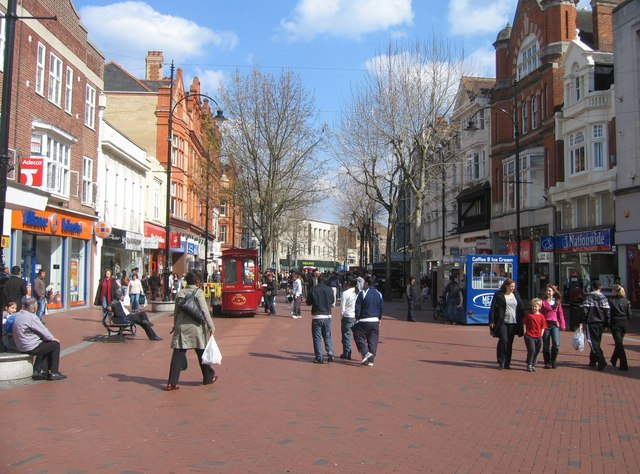

In [38]:
image

In [37]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")
model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")

# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

# forward pass
outputs = model(**inputs)

# use the `post_process_panoptic` method of `DetrFeatureExtractor` to convert to COCO format
processed_sizes = torch.as_tensor(inputs["pixel_values"].shape[-2:]).unsqueeze(0)
result = feature_extractor.post_process_panoptic(outputs, processed_sizes)[0]

# the segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result["png_string"]))
panoptic_seg_np = numpy.array(panoptic_seg, dtype=numpy.uint8)
# retrieve the ids corresponding to each mask
panoptic_seg_id = rgb_to_id(panoptic_seg_np)


/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are ini

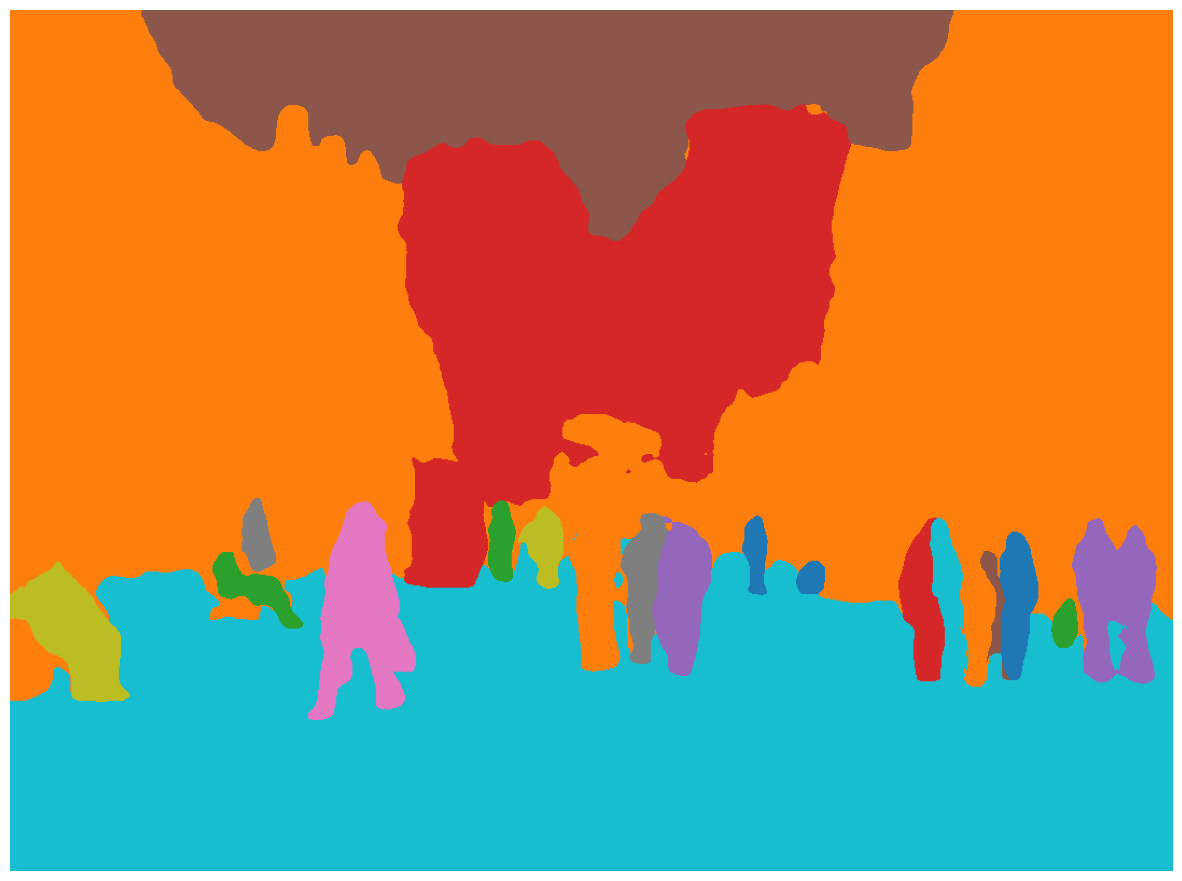

In [39]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

palette = itertools.cycle(sns.color_palette())

# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb_to_id(panoptic_seg)

# Finally we color each mask individually
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
  panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(panoptic_seg)
plt.axis('off')
plt.show()

In [40]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-w41o__uw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-w41o__uw
  Resolved https://github.com/facebookresearch/detectron2.git to commit 3ff5dd1cff4417af07097064813c9f28d7461d3c
  Preparing metadata (setup.py) ... done


In [41]:
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from google.colab.patches import cv2_imshow

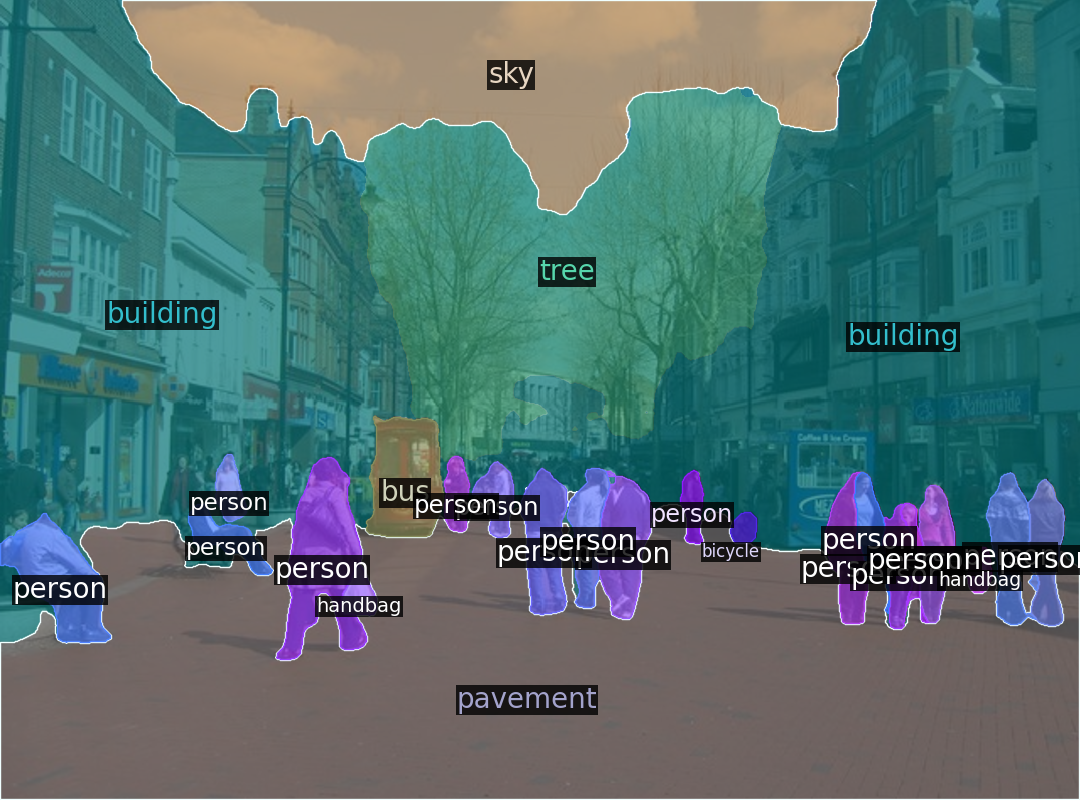

In [42]:
from copy import deepcopy
# We extract the segments info and the panoptic result from DETR's prediction
segments_info = deepcopy(result["segments_info"])
# Panoptic predictions are stored in a special format png
panoptic_seg = Image.open(io.BytesIO(result['png_string']))
final_w, final_h = panoptic_seg.size
# We convert the png into an segment id map
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8)
panoptic_seg = torch.from_numpy(rgb_to_id(panoptic_seg))



# Detectron2 uses a different numbering of coco classes, here we convert the class ids accordingly
meta = MetadataCatalog.get("coco_2017_val_panoptic_separated")
for i in range(len(segments_info)):
    c = segments_info[i]["category_id"]
    segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]


# Finally we visualize the prediction
v = Visualizer(numpy.array(image.copy().resize((final_w, final_h)))[:, :, ::-1], meta, scale=1.0)
v._default_font_size = 20
v = v.draw_panoptic_seg_predictions(panoptic_seg, segments_info, area_threshold=0)
cv2_imshow(v.get_image())

In [43]:
segments_info

[{'id': 0, 'isthing': True, 'category_id': 1, 'area': 680.0},
 {'id': 1, 'isthing': True, 'category_id': 0, 'area': 5031.0},
 {'id': 2, 'isthing': True, 'category_id': 0, 'area': 1520.0},
 {'id': 3, 'isthing': True, 'category_id': 5, 'area': 7859.0},
 {'id': 4, 'isthing': True, 'category_id': 0, 'area': 3807.0},
 {'id': 5, 'isthing': False, 'category_id': 40, 'area': 89955.0},
 {'id': 6, 'isthing': True, 'category_id': 26, 'area': 1219.0},
 {'id': 7, 'isthing': True, 'category_id': 0, 'area': 1470.0},
 {'id': 8, 'isthing': True, 'category_id': 0, 'area': 1987.0},
 {'id': 9, 'isthing': True, 'category_id': 0, 'area': 2289.0},
 {'id': 10, 'isthing': True, 'category_id': 0, 'area': 1230.0},
 {'id': 11, 'isthing': False, 'category_id': 50, 'area': 353233.0},
 {'id': 12, 'isthing': True, 'category_id': 26, 'area': 861.0},
 {'id': 13, 'isthing': False, 'category_id': 37, 'area': 102190.0},
 {'id': 14, 'isthing': True, 'category_id': 0, 'area': 5513.0},
 {'id': 15, 'isthing': True, 'category_